# Tutorial on CNN Classifiers with Pytorch Lightning

Code reference: https://pytorch-lightning.readthedocs.io/en/latest/notebooks/course_UvA-DL/04-inception-resnet-densenet.html

## Python imports

In [2]:
import os
import urllib.request
from types import SimpleNamespace
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

# %matplotlib inline
from IPython.display import HTML, display, set_matplotlib_formats
from PIL import Image
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR10

set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

/tmp/ipykernel_144861/2163690436.py:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")  # For export


## Configure environment

In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/home/kti03/Data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/ConvNets"


# Function for setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Global seed set to 42


## Load data and model checkpoints

In [4]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# Files to download
pretrained_files = [
    "GoogleNet.ckpt",
    "ResNet.ckpt",
    "ResNetPreAct.ckpt",
    "DenseNet.ckpt",
    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
    "tensorboards/ResNet/events.out.tfevents.resnet",
    "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
    "tensorboards/DenseNet/events.out.tfevents.densenet",
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

In [5]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0, 1, 2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /home/kti03/Data/cifar-10-python.tar.gz to /home/kti03/Data
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


We will use this information to define a transforms.Normalize module which will normalize our data accordingly. Additionally, we will use data augmentation during training. This reduces the risk of overfitting and helps CNNs to generalize better. Specifically, we will apply two random augmentations.

First, we will flip each image horizontally by a chance of 50% (transforms.RandomHorizontalFlip). The object class usually does not change when flipping an image, and we don't expect any image information to be dependent on the horizontal orientation. This would be however different if we would try to detect digits or letters in an image, as those have a certain orientation.

The second augmentation we use is called transforms.RandomResizedCrop. This transformation scales the image in a small range, while eventually changing the aspect ratio, and crops it afterward in the previous size. Therefore, the actual pixel values change while the content or overall semantics of the image stays the same.

We will randomly split the training dataset into a training and a validation set. The validation set will be used for determining early stopping. After finishing the training, we test the models on the CIFAR test set.

In [7]:
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(DATA_MEANS, DATA_STD)])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEANS, DATA_STD),
    ]
)
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Global seed set to 42
Global seed set to 42


Files already downloaded and verified


In [8]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0, 2, 3]))
print("Batch std", imgs.std(dim=[0, 2, 3]))

Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


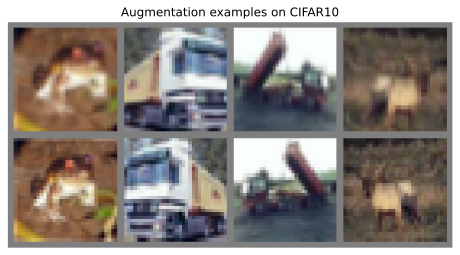

In [10]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

## Pytorch Lightning

In [13]:
pl.seed_everything(42)

Global seed set to 42


42

In PyTorch Lightning, we define pl.LightningModule's (inheriting from torch.nn.Module) that organize our code into 5 main sections:

1. Initialization (__init__), where we create all necessary parameters/models
2. Optimizers (configure_optimizers) where we create the optimizers, learning rate scheduler, etc.
3. Training loop (training_step) where we only have to define the loss calculation for a single batch (the loop of optimizer.zero_grad(), loss.backward() and  optimizer.step(), as well as any logging/saving operation, is done in the background)
4. Validation loop (validation_step) where similarly to the training, we only have to define what should happen per step
5. Test loop (test_step) which is the same as validation, only on a test set.

Therefore, we don't abstract the PyTorch code, but rather organize it and define some default operations that are commonly used. If you need to change something else in your training/validation/test loop, there are many possible functions you can overwrite (see the docs for details).

Now we can look at an example of how a Lightning Module for training a CNN looks like:

In [16]:
from lightning_systems.cifar10 import CIFARModule

In [17]:
model_dict = {}


def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f'Unknown model name "{model_name}". Available models are: {str(model_dict.keys())}'

In [18]:
act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU}

Besides the Lightning module, the second most important module in PyTorch Lightning is the Trainer. The trainer is responsible to execute the training steps defined in the Lightning module and completes the framework. Similar to the Lightning module, you can override any key part that you don't want to be automated, but the default settings are often the best practice to do. For a full overview, see the documentation. The most important functions we use below are:

- trainer.fit: Takes as input a lightning module, a training dataset, and an (optional) validation dataset. This function trains the given module on the training dataset with occasional validation (default once per epoch, can be changed)
- trainer.test: Takes as input a model and a dataset on which we want to test. It returns the test metric on the dataset.

For training and testing, we don't have to worry about things like setting the model to eval mode (model.eval()) as this is all done automatically. See below how we define a training function for our models:

In [19]:
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        gpus=1 if str(device) == "cuda:0" else 0,
        # How many epochs to train for if no patience is set
        max_epochs=180,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
        progress_bar_refresh_rate=1,
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = CIFARModule.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result